### 数据处理

In [3]:
import tushare as ts
import pandas as pd
# 设置 Tushare 的 API Token
token = "c576df5b626df4f37c30bae84520d70c7945a394d7ee274ef2685444"
ts.set_token(token)

In [4]:
# 定义股票代码列表
tickers = ['000009.SZ', '000012.SZ', '000021.SZ','000027.SZ','000031.SZ']

In [5]:
# 生成日期序列
start_date = '2014-12-31'
end_date = '2022-12-30'
date_index = pd.date_range(start=start_date, end=end_date, freq='B')
prices = pd.DataFrame(index=date_index)
market_prices = pd.DataFrame(index=date_index)

In [6]:
for ticker in tickers:
    df = ts.pro_bar(ts_code=ticker, adj='qfq', start_date=start_date, end_date=end_date)
    df = df.set_index(pd.to_datetime(df['trade_date']))
    prices = prices.join(df.close).rename(columns = {'close':ticker})

In [7]:
prices = prices.dropna()

In [8]:
import tushare as ts
result = ts.get_zz500s()
result

Excel file format cannot be determined, you must specify an engine manually.


In [9]:
import baostock as bs
import pandas as pd

# 登陆系统
lg = bs.login()
rs = bs.query_history_k_data_plus("sz.000905",
    "date,code,open,high,low,close,preclose,volume,amount,pctChg",
    start_date='2014-12-31', end_date='2022-12-30', frequency="d")
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)

login success!


In [10]:
result = result.set_index(pd.to_datetime(result['date']))
market_prices = market_prices.join(result.close).rename(columns = {'close':'csi500'})

In [11]:
market_prices = market_prices.dropna()

In [12]:
pro = ts.pro_api()

In [13]:
mcaps = {}
for ticker in tickers:
    df = pro.bak_daily(ts_code=ticker,start_date=start_date, end_date=end_date,fields='trade_date,ts_code,name,total_mv')
    mcaps[ticker] = df.iloc[-1,3]

Exception: 抱歉，您每天最多访问该接口50次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。

In [14]:
mcaps

{}

In [15]:
prices

,000009.SZ,000012.SZ,000021.SZ,000027.SZ,000031.SZ
2015-01-07,8.0589,5.3677,7.3629,5.6789,8.6110
2015-01-08,8.0710,5.4392,7.4854,5.4491,8.6673
2015-01-09,7.8473,5.2962,7.3157,5.2575,8.3580
2015-01-12,7.7385,5.0699,7.7305,5.0756,8.2456
2015-01-13,7.9924,5.0937,8.0794,5.0708,8.3487
...,...,...,...,...,...
2022-12-26,12.6200,6.8100,10.8000,5.8600,3.7800
2022-12-27,12.2600,6.8100,10.8700,6.0200,3.8100
2022-12-28,12.0500,6.7600,10.7000,6.0900,3.8800
2022-12-29,11.9800,6.6600,10.6500,6.1100,3.7500


In [16]:
market_prices

,csi500
2014-12-31,15.5500
2015-01-05,15.7100
2015-01-06,16.2400
2015-01-07,16.0200
2015-01-08,15.9300
...,...
2022-12-26,7.2900
2022-12-27,7.4000
2022-12-28,7.2700
2022-12-29,7.1200


### BL模型

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

In [18]:
mcaps = {'000009.SZ': 167.65,
 '000012.SZ': 189.69,
 '000021.SZ': 123.0,
 '000027.SZ': 268.4,
 '000031.SZ': 136.94}

In [19]:
prices

,000009.SZ,000012.SZ,000021.SZ,000027.SZ,000031.SZ
2015-01-07,8.0589,5.3677,7.3629,5.6789,8.6110
2015-01-08,8.0710,5.4392,7.4854,5.4491,8.6673
2015-01-09,7.8473,5.2962,7.3157,5.2575,8.3580
2015-01-12,7.7385,5.0699,7.7305,5.0756,8.2456
2015-01-13,7.9924,5.0937,8.0794,5.0708,8.3487
...,...,...,...,...,...
2022-12-26,12.6200,6.8100,10.8000,5.8600,3.7800
2022-12-27,12.2600,6.8100,10.8700,6.0200,3.8100
2022-12-28,12.0500,6.7600,10.7000,6.0900,3.8800
2022-12-29,11.9800,6.6600,10.6500,6.1100,3.7500


In [20]:
market_prices = market_prices['csi500'].astype(float)

In [21]:
market_prices

2014-12-31    15.55
2015-01-05    15.71
2015-01-06    16.24
2015-01-07    16.02
2015-01-08    15.93
              ...  
2022-12-26     7.29
2022-12-27     7.40
2022-12-28     7.27
2022-12-29     7.12
2022-12-30     7.22
Name: csi500, Length: 1948, dtype: float64

In [22]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
S

,000009.SZ,000012.SZ,000021.SZ,000027.SZ,000031.SZ
000009.SZ,0.312473,0.125388,0.134702,0.126535,0.102124
000012.SZ,0.125388,0.221878,0.098636,0.091700,0.085497
000021.SZ,0.134702,0.098636,0.261539,0.109820,0.105022
000027.SZ,0.126535,0.091700,0.109820,0.265788,0.133790
000031.SZ,0.102124,0.085497,0.105022,0.133790,0.244572


In [23]:
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

-0.07444384204194748

In [24]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

000009.SZ    0.008175
000012.SZ    0.010623
000021.SZ    0.010139
000027.SZ    0.008083
000031.SZ    0.010279
dtype: float64

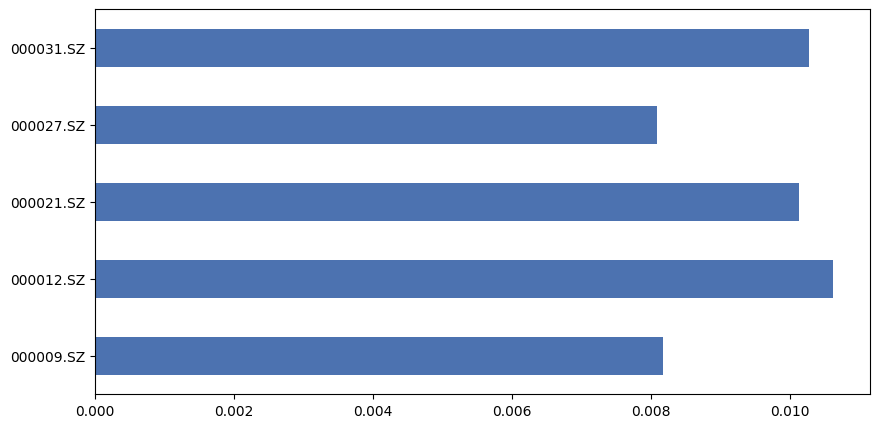

In [25]:
market_prior.plot.barh(figsize=(10,5));

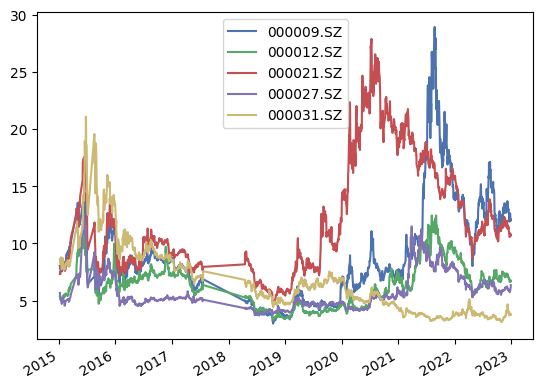

In [31]:
prices.plot()
plt.legend()
plt.show()

In [40]:
viewdict = {
    "000009.SZ": 0.1,
    "000021.SZ": 0.1,
}
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

In [42]:
confidences = [
    0.5,
    0.4,
]

In [43]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences,tau=1)

In [44]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

000009.SZ    0.061640
000012.SZ    0.037077
000021.SZ    0.056005
000027.SZ    0.035933
000031.SZ    0.034593
dtype: float64

In [45]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
000009.SZ,0.008175,0.061640,0.1
000012.SZ,0.010623,0.037077,NaN
000021.SZ,0.010139,0.056005,0.1
000027.SZ,0.008083,0.035933,NaN
000031.SZ,0.010279,0.034593,NaN


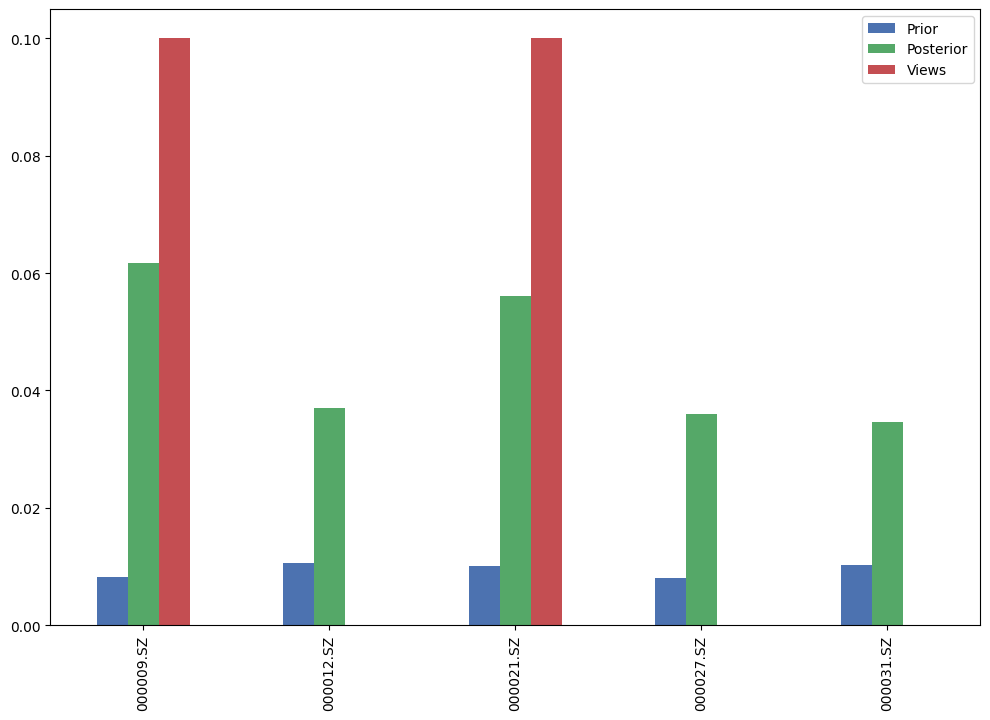

In [46]:
rets_df.plot.bar(figsize=(12,8));

In [47]:
from pypfopt import EfficientFrontier, objective_functions

In [48]:
S_bl = bl.bl_cov()

In [60]:
ef_og = EfficientFrontier(market_prior, S)
ef_bl = EfficientFrontier(ret_bl, S_bl)

In [61]:
def calcu_mw_weights(ef):
    ef.add_objective(objective_functions.L2_reg)
    ef.max_sharpe(risk_free_rate=0)
    weights = ef.clean_weights()
    return weights

In [62]:
weights_bl_mw = calcu_mw_weights(ef_bl)

/Users/afraaa/miniconda3/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


In [63]:
weights_og_mw = calcu_mw_weights(ef_og)

/Users/afraaa/miniconda3/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


In [132]:
from RiskParityModel import *

In [133]:
weights_og_rp = risk_parity_model(S,tickers)
weights_bl_rp = risk_parity_model(S_bl,tickers)

In [134]:
weights_og_rp

{'000009.SZ': 0.20861001553349773,
 '000012.SZ': 0.18716733569472208,
 '000021.SZ': 0.20223571804088933,
 '000027.SZ': 0.20462902037862404,
 '000031.SZ': 0.19735791035226688}

In [91]:
prices*weights_og_mw

,000009.SZ,000012.SZ,000021.SZ,000027.SZ,000031.SZ
2015-01-07,1.158950,1.348903,1.622783,0.866714,1.996633
2015-01-08,1.160691,1.366871,1.649782,0.831642,2.009687
2015-01-09,1.128520,1.330935,1.612380,0.802400,1.937969
2015-01-12,1.112874,1.274066,1.703802,0.774638,1.911907
2015-01-13,1.149387,1.280047,1.780700,0.773905,1.935813
...,...,...,...,...,...
2022-12-26,1.814882,1.711353,2.380320,0.894353,0.876469
2022-12-27,1.763111,1.711353,2.395748,0.918772,0.883425
2022-12-28,1.732911,1.698788,2.358280,0.929456,0.899656
2022-12-29,1.722844,1.673658,2.347260,0.932508,0.869513


In [88]:
weights_og_mw

OrderedDict([('000009.SZ', 0.14381),
             ('000012.SZ', 0.2513),
             ('000021.SZ', 0.2204),
             ('000027.SZ', 0.15262),
             ('000031.SZ', 0.23187)])

In [105]:
return_comparison = pd.DataFrame(columns = ['og_mw','bl_mw','og_rp','bl_rp'])

In [112]:
return_comparison['og_mw'] = (prices*weights_og_mw).sum(axis=1)

In [114]:
return_comparison['bl_mw'] = (prices*weights_bl_mw).sum(axis=1)

In [137]:
return_comparison['og_rp'] = (prices*weights_og_rp).sum(axis=1)
return_comparison['bl_rp'] = (prices*weights_bl_rp).sum(axis=1)

In [138]:
return_comparison

,og_mw,bl_mw,og_rp,bl_rp
2015-01-07,6.993983,7.232658,7.036383,7.017154
2015-01-08,7.018672,7.262006,7.041151,7.024251
2015-01-09,6.812205,7.059281,6.833151,6.816871
2015-01-12,6.777287,7.075006,6.792581,6.774404
2015-01-13,6.919852,7.271511,6.939927,6.919775
...,...,...,...,...
2022-12-26,7.677377,9.291928,8.036553,7.982296
2022-12-27,7.672409,9.222426,8.014271,7.961895
2022-12-28,7.619090,9.117061,7.954863,7.903474
2022-12-29,7.545783,9.051673,7.889868,7.837314


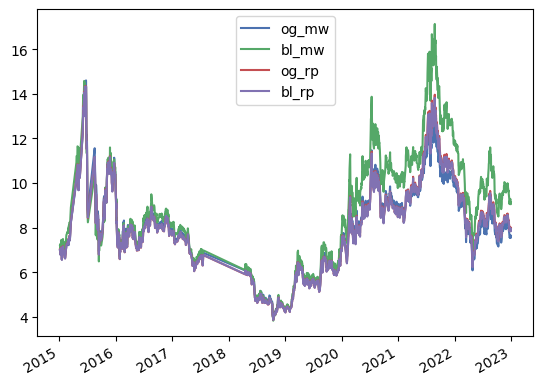

In [139]:
return_comparison.plot()
plt.legend()
plt.show()